In [235]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression



def load_dataset_train(data_num,test_type):
    # Set pandas to show all columns when you print a dataframe
    pd.set_option('display.max_columns', None)

    # Global setting here you choose the dataset number and classification type for the model
    dataset_number = data_num  # Options are [1, 2, 3, 4]
    test_type = test_type  # Options are ['label', 'attack_type']

    # Read the json and read it to a pandas dataframe object, you can change these settings
    # with open(f'./dataset_{str(dataset_number)}.json') as file:
    with open(f'./dataset_{str(dataset_number)}_train.json') as file:
        raw_ds = json.load(file)
    df = pd.json_normalize(raw_ds, max_level=2)

    # Shoe the first five lines of the dataframe to see if everything was read accordingly
    # print(df.head())
    print("load_dataset_train successfully")
    return df


def Fill_black_attack_with_Benign(df):
    # Fill the black attack tag lines with "Benign" string
    df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
    df['attack_type'] = df['request.Attack_Tag']
    print("Fill_black_attack_with_Benign successfully")
    return df


# This function will be used in the lambda below to iterate over the label columns
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'


# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
def renove_nan_columns(df):
    for column in df.columns[df.isna().any()].tolist():
        # df.drop(column, axis=1, inplace=True)
        df[column] = df[column].fillna('None')
    
    print("renove_nan_columns successfully")
    return df

  

dataset_number = 4  # Options are [1, 2, 3, 4]
test_type = 'label'  # Options are ['label', 'attack_type'] -- ch to at 
df = load_dataset_train(dataset_number,test_type)
df = Fill_black_attack_with_Benign(df)
df[test_type] = df.apply(lambda row: categorize(row), axis=1)
# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df = renove_nan_columns(df)

load_dataset_train successfully
Fill_black_attack_with_Benign successfully
renove_nan_columns successfully


In [236]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = [
         "request.headers.User-Agent",
        "request.headers.Accept-Encoding",
        "request.headers.Accept",
        "request.headers.Connection",
        "request.headers.Sec-Ch-Ua-Platform",
        "request.headers.Sec-Ch-Ua-Mobile",
        "request.headers.Accept-Language",
        "request.headers.Sec-Fetch-Site",
        "request.headers.Sec-Fetch-Mode",
        "request.headers.Cache-Control",
        "request.headers.Sec-Fetch-User",
        "request.headers.Sec-Fetch-Dest",
        "request.headers.Set-Cookie",
        "request.method",
        "request.url",
        "response.status",
        "response.headers.Content-Type",
        "response.status_code",
        "response.body",
        "response.headers.Location",
        "request.headers.Cookie",
        "request.headers.Content-Length",
        "response.headers.Set-Cookie",
        "request.headers.Upgrade-Insecure-Requests",
        "attack_type",
        "label",
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [ 
       
         ]


In [237]:
df.columns
for i in range(len(df.columns)):
    print(df.columns[i] , type(df.columns[i])) 

df.dtypes

request.headers.Host <class 'str'>
request.headers.User-Agent <class 'str'>
request.headers.Accept-Encoding <class 'str'>
request.headers.Accept <class 'str'>
request.headers.Connection <class 'str'>
request.headers.Sec-Ch-Ua-Platform <class 'str'>
request.headers.Sec-Ch-Ua-Mobile <class 'str'>
request.headers.Accept-Language <class 'str'>
request.headers.Sec-Fetch-Site <class 'str'>
request.headers.Sec-Fetch-Mode <class 'str'>
request.headers.Cache-Control <class 'str'>
request.headers.Sec-Fetch-User <class 'str'>
request.headers.Sec-Fetch-Dest <class 'str'>
request.headers.Set-Cookie <class 'str'>
request.headers.Date <class 'str'>
request.method <class 'str'>
request.url <class 'str'>
request.body <class 'str'>
response.status <class 'str'>
response.headers.Content-Type <class 'str'>
response.headers.Content-Length <class 'str'>
response.status_code <class 'str'>
response.body <class 'str'>
response.headers.Location <class 'str'>
request.headers.Cookie <class 'str'>
request.headers.

request.headers.Host                         object
request.headers.User-Agent                   object
request.headers.Accept-Encoding              object
request.headers.Accept                       object
request.headers.Connection                   object
request.headers.Sec-Ch-Ua-Platform           object
request.headers.Sec-Ch-Ua-Mobile             object
request.headers.Accept-Language              object
request.headers.Sec-Fetch-Site               object
request.headers.Sec-Fetch-Mode               object
request.headers.Cache-Control                object
request.headers.Sec-Fetch-User               object
request.headers.Sec-Fetch-Dest               object
request.headers.Set-Cookie                   object
request.headers.Date                         object
request.method                               object
request.url                                  object
request.body                                 object
response.status                              object
response.hea

In [238]:
# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS:
        if column in df.columns:
            df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    # for column in COMPLEX_HEADERS: 
    #     newHVec = h_vec.fit_transform(df[column])
    #     df[column] = newHVec.todense()

    # # Remove some columns that may be needed.. (Or not, you decide)
    # for column in COLUMNS_TO_REMOVE: 
    #     df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)

In [239]:
def feature_selection(df,test_type,feature_list):
  X = df[feature_list].to_numpy()
  # print(X)
  # This column is the desired prediction we will train our model on
  y = np.stack(df[test_type])
  # We split the dataset to train and test according to the required ration
  # Do not change the test_size -> you can change anything else
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=50, stratify=y)
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train,y_train)
  sort = clf.feature_importances_.argsort()
  updated_feature_list = []
  for i in sort:
    # we change the value according to outcome
    if clf.feature_importances_[i] > 0.01:
        updated_feature_list.append(feature_list[i])
        # print the feature with his effect \ importances 
    print("feature: " , feature_list[i]," ",clf.feature_importances_[i]," ",i)
  print(len(feature_list))
  print(len(updated_feature_list))
  return updated_feature_list

features_list = df.columns.to_list()
if 'label' in features_list:
  features_list.remove('label')
if 'attack_type' in features_list:
  features_list.remove('attack_type')
if 'request.body' in features_list:
  features_list.remove('request.body')
if 'request.body' in features_list:
  features_list.remove('request.body')
if 'response.headers.Content-Length' in features_list:
  features_list.remove('response.headers.Content-Length')
if 'request.headers.Date' in features_list:
  features_list.remove('request.headers.Date')
if 'request.headers.Host' in features_list:
  features_list.remove('request.headers.Host')
print(features_list)
updated_feature_list = feature_selection(df,test_type, features_list)
print(updated_feature_list)


['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Cache-Control', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'request.headers.Upgrade-Insecure-Requests']
feature:  request.headers.Accept   0.0   2
feature:  request.headers.Connection   0.0   3
feature:  request.method   0.004107895668706188   13
feature:  response.headers.Set-Cookie   0.004131075251850576   22
feature:  request.headers.Cache-Control   0.006043404299938548   9
fea

In [193]:
# updated_feature_list.remove('label')
# updated_feature_list.remove('attack_type')

In [240]:
print("features to remove")
for f in features_list:
    if f not in updated_feature_list:
        print(f)

features to remove
request.headers.Accept
request.headers.Connection
request.headers.Cache-Control
request.method
response.headers.Set-Cookie


In [241]:

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date',
                    'request.headers.Host',
                    'request.headers.Accept',
                    'request.headers.Connection',
                    'request.headers.Sec-Fetch-User',
                    'request.method',
                    'response.headers.Set-Cookie']

In [242]:
 # # Remove some columns that may be needed.. (Or not, you decide)
def remove_columns(df,columns_to_remmove):    
    for column in columns_to_remmove: 
        if column in df.columns:
            df.drop(column, axis=1, inplace=True)
    print("columns removed successfully")
    return df
df = remove_columns(df,COLUMNS_TO_REMOVE)
# print(df.columns)
df.dtypes

columns removed successfully


request.headers.User-Agent                   int32
request.headers.Accept-Encoding              int32
request.headers.Sec-Ch-Ua-Platform           int32
request.headers.Sec-Ch-Ua-Mobile             int32
request.headers.Accept-Language              int32
request.headers.Sec-Fetch-Site               int32
request.headers.Sec-Fetch-Mode               int32
request.headers.Cache-Control                int32
request.headers.Sec-Fetch-Dest               int32
request.headers.Set-Cookie                   int32
request.url                                  int32
response.status                              int32
response.headers.Content-Type                int32
response.status_code                         int64
response.body                                int32
response.headers.Location                    int32
request.headers.Cookie                       int32
request.headers.Content-Length               int32
request.headers.Upgrade-Insecure-Requests    int32
attack_type                    

In [243]:
if 'request.headers.Sec-Fetch-User' in updated_feature_list:
  features_list.remove('request.headers.Sec-Fetch-User')



Train test split

In [244]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
updated_feature_list_new = []
for i in updated_feature_list:
    if i in df.columns:
        updated_feature_list_new.append(i)
X = df[updated_feature_list_new].to_numpy()


# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 18) (150508,)
(32259, 18) (32259,)


Counter({0: 143297, 1: 39470})

in order to change from val to x_test see the code below

In [245]:
# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df_val(df_val,updated_feature_list):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    # for column in updated_feature_list: 
    #     if column in df.columns:
    #         df[column] = le.fit_transform(df[column])

    for column in df.columns:
        if column in df_val.columns:
            df_val[column] = le.fit_transform(df_val[column])

        # try:
        #     newHVec = h_vec.fit_transform(df[column])
        #     df[column] = newHVec.todense()
        # except:
        #     df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    # for column in COMPLEX_HEADERS: 
    #     newHVec = h_vec.fit_transform(df[column])
    #     df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    df_val = remove_columns(df_val,COLUMNS_TO_REMOVE)
    return df_val

In [246]:
SIMPLE_HEADERS_VAL = [
 'request.headers.Host'                         
,'request.headers.User-Agent'                   
,'request.headers.Accept-Encoding'              
,'request.headers.Accept'                       
,'request.headers.Connection'                   
,'request.headers.Sec-Ch-Ua-Mobile'             
,'request.headers.Accept-Language'              
,'request.headers.Sec-Fetch-Site'               
,'request.headers.Sec-Fetch-Mode'               
,'request.headers.Cache-Control'                
,'request.headers.Sec-Fetch-User'               
,'request.headers.Sec-Fetch-Dest'               
,'request.headers.Set-Cookie'                   
,'request.headers.Date'                         
,'request.method'                               
,'request.url'                                  
,'request.body'                                 
,'response.status'                              
,'response.headers.Content-Type'                
,'response.headers.Content-Length'              
,'response.status_code'                         
,'response.body'                                
,'request.headers.Sec-Ch-Ua-Platform'           
,'request.headers.Content-Length'               
,'response.headers.Location'                    
,'request.headers.Cookie'                       
,'response.headers.Set-Cookie'                  
,'request.headers.Upgrade-Insecure-Requests' ]   

In [247]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df_val = pd.json_normalize(raw_ds, max_level=2)

for column in test_df_val.columns[test_df_val.isna().any()].tolist():
     test_df_val[column] = test_df_val[column].fillna('None')

# print(test_df_val.dtypes)
test_df_val = remove_columns(test_df_val,COLUMNS_TO_REMOVE)
test_df_val = vectorize_df_val(test_df_val,SIMPLE_HEADERS_VAL)
print(test_df_val.dtypes)

Val_Test = test_df_val[updated_feature_list].to_numpy()

# if you want to test the val dont mark this row below 
# X_test = Val_Test


columns removed successfully
columns removed successfully
request.headers.User-Agent                   int32
request.headers.Accept-Encoding              int32
request.headers.Sec-Ch-Ua-Mobile             int32
request.headers.Accept-Language              int32
request.headers.Sec-Fetch-Site               int32
request.headers.Sec-Fetch-Mode               int32
request.headers.Cache-Control                int32
request.headers.Sec-Fetch-Dest               int32
request.headers.Set-Cookie                   int32
request.url                                  int32
response.status                              int32
response.headers.Content-Type                int32
response.status_code                         int64
response.body                                int32
request.headers.Sec-Ch-Ua-Platform           int32
request.headers.Content-Length               int32
response.headers.Location                    int32
request.headers.Cookie                       int32
request.headers.Upgrade-

KeyError: "['request.headers.Sec-Fetch-User'] not in index"

algo 

In [248]:
def random_forest_classifier(X_train, y_train,X_test):
    # We choose our model of choice and set it's hyper parameters you can change anything
    clf = RandomForestClassifier(n_estimators=100)
    # Train Model
    clf.fit(X_train, y_train)
    # print(clf.predict())
    return clf.predict(X_test)

def KNeighbors_classifier(X_train, y_train,X_test):
    model = KNeighborsClassifier(n_neighbors=7)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def decision_Tree_classifier(X_train, y_train,X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)
 
def gaussianNB(X_train, y_train,X_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def svm_LinearSVC(X_train, y_train,X_test):
    model = svm.LinearSVC(random_state=800,max_iter=400)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def SGD_classifier(X_train, y_train,X_test):
    model = SGDClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def logistic_regression(X_train, y_train,X_test):
    model = LogisticRegression(max_iter=300)
    model.fit(X_train, y_train)
    return model.predict(X_test) 

In [249]:
randomForestClassifier_predictions = random_forest_classifier(X_train,y_train,X_test)


In [250]:
KNeighborsClassifier_prediction = KNeighbors_classifier(X_train,y_train,X_test)


In [251]:
decisionTreeClassifier_perdiction = decision_Tree_classifier(X_train,y_train,X_test)


In [252]:
gaussianNB_prediction = gaussianNB(X_train,y_train,X_test)


In [253]:
linearSVC_prediction = svm_LinearSVC(X_train,y_train,X_test)


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [254]:
SGDClassifier_prediction = SGD_classifier(X_train,y_train,X_test)


In [255]:
logisticRegression_prediction = logistic_regression(X_train,y_train,X_test)


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [256]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Train the classifier on some data
xx_train = [[0, 1], [1, 1], [0, 0], [1, 0]]
yy_train = [0, 1, 0, 1]
clf.fit(xx_train, yy_train)

# Use the classifier to make predictions on some new data
xx_test = [[0, 0], [1, 0], [0, 1], [0, 0]]
predictions = clf.predict(xx_test)

print(predictions)  # prints [0, 1, 0, 1]

[0 1 0 0]


prediction

In [257]:

# prediction = []



# for  i in range(len(randomForestClassifier_predictions)):
#     tmpans = str()
#     count = 0 
#     Benign = "0"

#     if str(randomForestClassifier_predictions[i]) == Benign:
#         # count += 12.5
#         # count += 14.1
#         count += 18.02 
#     if str(logisticRegression_prediction[i]) == Benign:
#         # count += 12.5
#         # count += 13.175
#         count += 15.175
#     if str(KNeighborsClassifier_prediction[i]) == Benign:
#         # count += 12.5
#         # count += 13.485
#         count += 15.485
#     if str(decisionTreeClassifier_perdiction[i]) == Benign:
#         # count += 12.5
#         # count += 13.64
#         count += 15.64
#     # if str(baggingClassifier_predidtion[i]) == "Benign":
#     #     # count += 12.5
#     #     # count += 9.92
#     #     count += 8.92
#     if str(gaussianNB_prediction[i]) == Benign:
#         # count += 12.5
#         # count += 12.09
#         count += 12.09
#     if str(linearSVC_prediction[i]) == Benign:
#         # count += 12.5
#         # count += 11.78
#         count += 11.78

#     if str(SGDClassifier_prediction[i]) == Benign:
#         # count += 12.5
#         # count += 11.625
#         count += 11.625

#     if count >= 85:
#         tmpans = 0
#     else:
#         tmpans = 1
    
#     prediction.append(tmpans)


# # clf_end_report = classification_report(y_test, prediction, digits=5)

# # print(clf_end_report)

# # Save your preditions
# enc = LabelEncoder()
# np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(prediction), fmt='%2d')


[(0, 99.815)]
[(1, 64.32), (0, 35.495)]
[(0, 50.67), (1, 49.144999999999996)]
[(0, 84.64), (1, 15.175)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(0, 99.815)]
[(1, 64.32), (0, 35.495)]
[(0, 50.98), (1, 48.835)]
[(0, 84.33), (1, 15.485)]
[(0, 99.815)]
[(0, 99.815)]
              precision    recall  f1-score   support

           0    0.98681   0.99992   0.99332     25292
           1    0.99970   0.95149   0.97500      6967

    accuracy                        0.98946     32259
   macro avg    0.99325   0.97570   0.98416     32259
weighted avg    0.98959   0.98946   0.98936     32259



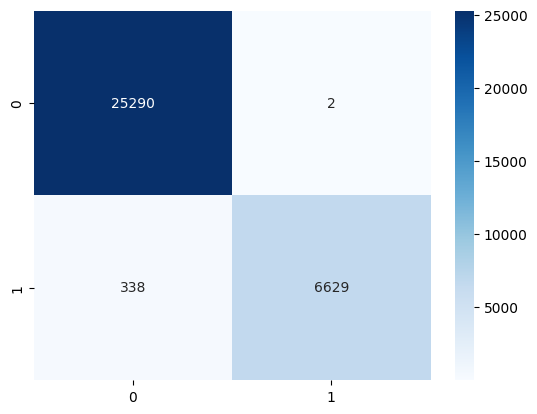

In [258]:
prediction = []
def sort_dictionary_by_value(d):
    # sort the dictionary by value and return a list of tuples (key, value)
    return sorted(d.items(), key=lambda x: x[1], reverse=True)

for  i in range(len(randomForestClassifier_predictions)):
    predictionNew = {}
    tmpans = str()
    count = 0 
    Benign = "0"

    if randomForestClassifier_predictions[i] in predictionNew:
        predictionNew[randomForestClassifier_predictions[i]] += 18.02
    else:
        predictionNew[randomForestClassifier_predictions[i]] = 18.02
  
      
    if logisticRegression_prediction[i] in predictionNew:
        predictionNew[logisticRegression_prediction[i]] += 15.175
    else:
        predictionNew[logisticRegression_prediction[i]] = 15.175
   

    if KNeighborsClassifier_prediction[i] in predictionNew:
        predictionNew[KNeighborsClassifier_prediction[i]] += 15.485
    else:
        predictionNew[KNeighborsClassifier_prediction[i]] = 15.485


    if decisionTreeClassifier_perdiction[i] in predictionNew:
        predictionNew[decisionTreeClassifier_perdiction[i]] += 15.64
    else:
        predictionNew[decisionTreeClassifier_perdiction[i]] = 15.64


    if gaussianNB_prediction[i] in predictionNew:
        predictionNew[gaussianNB_prediction[i]] += 12.09
    else:
        predictionNew[gaussianNB_prediction[i]] = 12.09


    if linearSVC_prediction[i] in predictionNew:
        predictionNew[linearSVC_prediction[i]] += 11.78
    else:
        predictionNew[linearSVC_prediction[i]] = 11.78


    if SGDClassifier_prediction[i] in predictionNew:
        predictionNew[SGDClassifier_prediction[i]] += 11.625
    else:
        predictionNew[SGDClassifier_prediction[i]] = 11.625

    d = sort_dictionary_by_value(predictionNew) 
    if i < 20 :
        print(d)
    prediction.append(d[0][0])
    
# clf_end_report = classification_report(true_labels, prediction, digits=5)
cf_matrix = confusion_matrix(y_test, randomForestClassifier_predictions)
clf_report = classification_report(y_test, randomForestClassifier_predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(y_test), 
                      yticklabels=np.unique(y_test)) 
# The heatmap is cool but this is the most important result
print(clf_report)
# enc = LabelEncoder()
# np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(prediction), fmt='%2d')